# Imports & Data Initialization

In [44]:
import numpy as np
import awkward as ak
import pandas as pd
import matplotlib.pyplot as plt

In [45]:
# Load parquet files converted from ROOT
ak_arrayA = ak.from_parquet("data/extracted_dataA.parquet")
ak_arrayB = ak.from_parquet("data/extracted_dataB.parquet")
ak_arrayC = ak.from_parquet("data/extracted_dataC.parquet")
ak_arrayD = ak.from_parquet("data/extracted_dataD.parquet")

ak_array1 = ak.from_parquet("data/extracted_mcgg.parquet")
ak_array2 = ak.from_parquet("data/extracted_mcVBF.parquet")
ak_array3 = ak.from_parquet("data/extracted_mcW.parquet")
ak_array4 = ak.from_parquet("data/extracted_mcZ.parquet")

ak_arraybkg = ak.from_parquet("data/extracted_mcbkg.parquet")

# Convert awkward arrays to pandas DataFrames
dfA = pd.DataFrame({k: ak_arrayA[k].to_list() for k in ak_arrayA.fields})
dfB = pd.DataFrame({k: ak_arrayB[k].to_list() for k in ak_arrayB.fields})
dfC = pd.DataFrame({k: ak_arrayC[k].to_list() for k in ak_arrayC.fields})
dfD = pd.DataFrame({k: ak_arrayD[k].to_list() for k in ak_arrayD.fields})

# Full data sample
df = pd.concat([dfA, dfB, dfC, dfD], ignore_index=True)

# Signal MC (all Higgs production modes combined)
df1 = pd.DataFrame({k: ak_array1[k].to_list() for k in ak_array1.fields})
df2 = pd.DataFrame({k: ak_array2[k].to_list() for k in ak_array2.fields})
df3 = pd.DataFrame({k: ak_array3[k].to_list() for k in ak_array3.fields})
df4 = pd.DataFrame({k: ak_array4[k].to_list() for k in ak_array4.fields})
df_sig = pd.concat([df1, df2, df3, df4], ignore_index=True)

# Background MC
df_bkg = pd.DataFrame({k: ak_arraybkg[k].to_list() for k in ak_arraybkg.fields})

print(np.shape(df), np.shape(df_sig), np.shape(df_bkg))
print(df_bkg.columns)


(832, 12) (385706, 12) (554279, 12)
Index(['lep_charge', 'lep_pt', 'lep_eta', 'lep_phi', 'lep_E', 'lep_type',
       'lep_isTightID', 'lep_ptcone30', 'lep_etcone20', 'mcWeight',
       'runNumber', 'met_et'],
      dtype='object')


### Normalization attempt #1

In [64]:
import numpy as np
import awkward as ak
import pandas as pd

# -------------------------
# Load parquet files converted from ROOT
# -------------------------
ak_arrayA = ak.from_parquet("data/extracted_dataA.parquet")
ak_arrayB = ak.from_parquet("data/extracted_dataB.parquet")
ak_arrayC = ak.from_parquet("data/extracted_dataC.parquet")
ak_arrayD = ak.from_parquet("data/extracted_dataD.parquet")

ak_array1 = ak.from_parquet("data/extracted_mcgg.parquet")   # ggF
ak_array2 = ak.from_parquet("data/extracted_mcVBF.parquet")  # VBF
ak_array3 = ak.from_parquet("data/extracted_mcW.parquet")    # WH
ak_array4 = ak.from_parquet("data/extracted_mcZ.parquet")    # ZH

ak_arraybkg = ak.from_parquet("data/extracted_mcbkg.parquet")

# -------------------------
# Convert awkward arrays to pandas DataFrames
# -------------------------
dfA = pd.DataFrame({k: ak_arrayA[k].to_list() for k in ak_arrayA.fields})
dfB = pd.DataFrame({k: ak_arrayB[k].to_list() for k in ak_arrayB.fields})
dfC = pd.DataFrame({k: ak_arrayC[k].to_list() for k in ak_arrayC.fields})
dfD = pd.DataFrame({k: ak_arrayD[k].to_list() for k in ak_arrayD.fields})

# Full data sample
df = pd.concat([dfA, dfB, dfC, dfD], ignore_index=True)

# -------------------------
# MC normalization parameters
# -------------------------
LUMINOSITY = 10.0  # fb^-1

# Cross sections (pb) at 13 TeV, mH = 125 GeV
XS = {
    "ggF": 48.6,
    "VBF": 3.78,
    "WH": 1.37,
    "ZH": 0.88,
    "bkg": 16.0  # pp → ZZ (pb)
}

# Branching ratios
BR_H_4L = 5.0e-4      # H → ZZ* → 4ℓ
BR_ZZ_4L = 4.5e-3     # ZZ → 4ℓ (sum of 4e, 4μ, 2e2μ)

# -------------------------
# Signal MC
# -------------------------
df1 = pd.DataFrame({k: ak_array1[k].to_list() for k in ak_array1.fields})
df2 = pd.DataFrame({k: ak_array2[k].to_list() for k in ak_array2.fields})
df3 = pd.DataFrame({k: ak_array3[k].to_list() for k in ak_array3.fields})
df4 = pd.DataFrame({k: ak_array4[k].to_list() for k in ak_array4.fields})

# Assign per-event weights including BR and luminosity
df1["weight"] = XS["ggF"] * BR_H_4L * LUMINOSITY * 1000 / len(df1)
df2["weight"] = XS["VBF"] * BR_H_4L * LUMINOSITY * 1000 / len(df2)
df3["weight"] = XS["WH"]  * BR_H_4L * LUMINOSITY * 1000 / len(df3)
df4["weight"] = XS["ZH"]  * BR_H_4L * LUMINOSITY * 1000 / len(df4)

# Combine all signal samples
df_sig = pd.concat([df1, df2, df3, df4], ignore_index=True)

# -------------------------
# Background MC
# -------------------------
df_bkg = pd.DataFrame({k: ak_arraybkg[k].to_list() for k in ak_arraybkg.fields})
df_bkg["weight"] = XS["bkg"] * BR_ZZ_4L * LUMINOSITY * 1000 / len(df_bkg)

# -------------------------
# Quick sanity check
# -------------------------
print("Shapes:", np.shape(df), np.shape(df_sig), np.shape(df_bkg))
print("Columns in background MC:", df_bkg.columns)
print("Total expected signal (10 fb^-1):", df_sig["weight"].sum())
print("Total expected background (10 fb^-1):", df_bkg["weight"].sum())

Shapes: (832, 12) (385706, 13) (554279, 13)
Columns in background MC: Index(['lep_charge', 'lep_pt', 'lep_eta', 'lep_phi', 'lep_E', 'lep_type',
       'lep_isTightID', 'lep_ptcone30', 'lep_etcone20', 'mcWeight',
       'runNumber', 'met_et', 'weight'],
      dtype='object')
Total expected signal (10 fb^-1): 273.15000000000003
Total expected background (10 fb^-1): 720.0000000000002


### Normalization attempt #2

In [70]:
import numpy as np
import awkward as ak
import pandas as pd

# -------------------------
# Load parquet files
# -------------------------
ak_arrayA = ak.from_parquet("data/extracted_dataA.parquet")
ak_arrayB = ak.from_parquet("data/extracted_dataB.parquet")
ak_arrayC = ak.from_parquet("data/extracted_dataC.parquet")
ak_arrayD = ak.from_parquet("data/extracted_dataD.parquet")

ak_array1 = ak.from_parquet("data/extracted_mcgg.parquet")   # ggF
ak_array2 = ak.from_parquet("data/extracted_mcVBF.parquet")  # VBF
ak_array3 = ak.from_parquet("data/extracted_mcW.parquet")    # WH
ak_array4 = ak.from_parquet("data/extracted_mcZ.parquet")    # ZH

ak_arraybkg = ak.from_parquet("data/extracted_mcbkg.parquet")

# -------------------------
# Convert to pandas
# -------------------------
dfA = pd.DataFrame({k: ak_arrayA[k].to_list() for k in ak_arrayA.fields})
dfB = pd.DataFrame({k: ak_arrayB[k].to_list() for k in ak_arrayB.fields})
dfC = pd.DataFrame({k: ak_arrayC[k].to_list() for k in ak_arrayC.fields})
dfD = pd.DataFrame({k: ak_arrayD[k].to_list() for k in ak_arrayD.fields})

df = pd.concat([dfA, dfB, dfC, dfD], ignore_index=True)

# -------------------------
# MC normalization parameters
# -------------------------
LUMINOSITY = 10.0  # fb^-1

# 13 TeV Higgs production cross sections (pb)
XS = {
    "ggF": 48.6,
    "VBF": 3.78,
    "WH": 1.37,
    "ZH": 0.88,
    "bkg": 16.0  # ZZ production (pb)
}

# Branching ratios
BR_H_4L = 1.24e-3    # H → ZZ* → 4ℓ (4e, 4μ, 2e2μ)
BR_ZZ_4L = 4.52e-3   # ZZ → 4ℓ

# -------------------------
# Signal MC
# -------------------------
df1 = pd.DataFrame({k: ak_array1[k].to_list() for k in ak_array1.fields})
df2 = pd.DataFrame({k: ak_array2[k].to_list() for k in ak_array2.fields})
df3 = pd.DataFrame({k: ak_array3[k].to_list() for k in ak_array3.fields})
df4 = pd.DataFrame({k: ak_array4[k].to_list() for k in ak_array4.fields})

# Assign weights (σ × BR × L / N_gen)
df1["weight"] = XS["ggF"] * BR_H_4L * LUMINOSITY * 1000 / len(df1)
df2["weight"] = XS["VBF"] * BR_H_4L * LUMINOSITY * 1000 / len(df2)
df3["weight"] = XS["WH"]  * BR_H_4L * LUMINOSITY * 1000 / len(df3)
df4["weight"] = XS["ZH"]  * BR_H_4L * LUMINOSITY * 1000 / len(df4)

df_sig = pd.concat([df1, df2, df3, df4], ignore_index=True)

# -------------------------
# Background MC
# -------------------------
df_bkg = pd.DataFrame({k: ak_arraybkg[k].to_list() for k in ak_arraybkg.fields})
df_bkg["weight"] = XS["bkg"] * BR_ZZ_4L * LUMINOSITY * 1000 / len(df_bkg)

# -------------------------
# Sanity check
# -------------------------
print("Shapes:", np.shape(df), np.shape(df_sig), np.shape(df_bkg))
print("Total expected signal (10 fb^-1):", df_sig["weight"].sum())
print("Total expected background (10 fb^-1):", df_bkg["weight"].sum())


Shapes: (832, 12) (385706, 13) (554279, 13)
Total expected signal (10 fb^-1): 677.4119999999999
Total expected background (10 fb^-1): 723.1999999999998


# Event selection

### 4-Lepton Selection

In [71]:
# Require exactly four leptons forming 4e, 4mu, or 2e2mu final states
def lep_channel(lep_type):
    lep_type = np.array(lep_type)
    n_e  = np.sum(lep_type == 11)
    n_mu = np.sum(lep_type == 13)
    return (n_e == 4) or (n_mu == 4) or (n_e == 2 and n_mu == 2)

mask_data = df['lep_type'].apply(lep_channel)
mask_sig  = df_sig['lep_type'].apply(lep_channel)
mask_bkg  = df_bkg['lep_type'].apply(lep_channel)

# 4-lepton data
data_4l = df[mask_data]
sig_4l  = df_sig[mask_sig]
bkg_4l  = df_bkg[mask_bkg]

print("4l events:", data_4l.shape)


4l events: (606, 12)


### Cuts

In [72]:
# Individual cut functions (for cutflow bookkeeping)

### Forward tracks cut
def cut_eta(event):
    eta = np.abs(np.array(event['lep_eta']))
    return np.all(eta < 2.45)

### Transverse momentum cut (electron, muon)
def cut_pt_flavor(event):
    pt = np.array(event['lep_pt']) / 1000
    t  = np.array(event['lep_type'])
    pass_e  = (t != 11) | (pt > 15)
    pass_mu = (t != 13) | (pt > 13)
    return np.all(pass_e & pass_mu)

### Tight ID cut
def cut_tight_id(event):
    return np.all(event['lep_isTightID'])

### Isolation cut
def cut_isolation(event):
    pt = np.array(event['lep_pt']) / 1000
    ptcone = np.array(event['lep_ptcone30']) / 1000
    return np.all(ptcone / pt < 0.15)

### Leading/subleading/third momentum cut 
def cut_leading_pt(event):
    pt = np.array(event['lep_pt']) / 1000
    pt_sorted = np.sort(pt)[::-1]
    return (pt_sorted[0] > 25) and (pt_sorted[1] > 20) and (pt_sorted[2] > 15)

# Z1 / Z2 reconstruction and mass window selection cut
def z_mass_cut(event):
    pt = np.array(event['lep_pt']) / 1000
    eta = np.abs(np.array(event['lep_eta']))
    phi = np.array(event['lep_phi'])
    t = np.array(event['lep_type'])
    E = np.array(event['lep_E']) / 1000
    charge = np.array(event['lep_charge'])
    
    def inv_mass(E, pt, eta, phi):
        px = pt * np.cos(phi)
        py = pt * np.sin(phi)
        pz = pt * np.sinh(eta)
        E_tot  = np.sum(E)
        px_tot = np.sum(px)
        py_tot = np.sum(py)
        pz_tot = np.sum(pz)
        m2 = E_tot**2 - (px_tot**2 + py_tot**2 + pz_tot**2)
        return np.sqrt(np.maximum(m2, 0))
        
    # Find all same-flavor opposite-sign lepton pairs
    sfos_pairs = []
    for i in range(4):
        for j in range(i+1, 4):
            if (t[i] == t[j]) and (charge[i] * charge[j] == -1):
                sfos_pairs.append((i, j))
    
    if len(sfos_pairs) < 2:
        return False

    # Leading Z = pair closest to mZ
    mZ = 90
    masses = [inv_mass(E[[i,j]], pt[[i,j]], eta[[i,j]], phi[[i,j]]) for i,j in sfos_pairs]
    idx = np.argmin(np.abs(np.array(masses) - mZ))
    i, j = sfos_pairs[idx]
    m12 = masses[idx]

    # Subleading Z from remaining leptons
    rem = list({0,1,2,3} - {i, j})
    m34 = inv_mass(E[rem], pt[rem], eta[rem], phi[rem])

    # Z mass windows
    if not (50 < m12 < 106):
        return False
    if not (12 < m34 < 115):
        return False
    
    return True


In [73]:
# Sequential application of cuts (for cutflow)
cuts = [
    ("4 leptons", None),
    ("|η| < 2.45", cut_eta),
    ("pT (flavor)", cut_pt_flavor),
    ("Tight ID", cut_tight_id),
    ("Isolation", cut_isolation),
    ("Leading pT", cut_leading_pt),
    ("Z mass window", z_mass_cut),
]

def apply_cut(df, cut_func):
    if cut_func is None:
        return df
    return df[df.apply(cut_func, axis=1)]

# Containers for cutflow
cutflow = []

data_tmp, sig_tmp, bkg_tmp = data_4l, sig_4l, bkg_4l

for name, func in cuts:
    data_tmp = apply_cut(data_tmp, func)
    sig_tmp  = apply_cut(sig_tmp, func)
    bkg_tmp  = apply_cut(bkg_tmp, func)

    cutflow.append({
        "Cut": name,
        "Data": len(data_tmp),
        "Signal (MC, 10 fb⁻¹)": sig_tmp['weight'].sum(),
        "Background (MC, 10 fb⁻¹)": bkg_tmp['weight'].sum()
    })

# Final selected datasets (after all cuts)
data_sel = data_tmp
sig_sel  = sig_tmp
bkg_sel  = bkg_tmp

cutflow_df = pd.DataFrame(cutflow)
cutflow_df

,Cut,Data,"Signal (MC, 10 fb⁻¹)","Background (MC, 10 fb⁻¹)"
0,4 leptons,606,664.846682,697.145286
1,|η| < 2.45,579,651.238730,670.761773
2,pT (flavor),256,196.202388,440.902543
3,Tight ID,152,143.115787,328.900806
4,Isolation,140,128.561603,311.700180
5,Leading pT,140,123.327023,310.204927
6,Z mass window,130,104.139160,279.040781


# Results

### Four-Lepton Invariant Mass

In [80]:
# Compute four-lepton invariant mass
def compute_m4l(event):
    pt  = np.array(event['lep_pt']) * 1e-3  # GeV
    eta = np.array(event['lep_eta'])
    phi = np.array(event['lep_phi'])
    E   = np.array(event['lep_E']) * 1e-3  # GeV

    px = pt * np.cos(phi)
    py = pt * np.sin(phi)
    pz = pt * np.sinh(eta)

    E_tot  = np.sum(E)
    px_tot = np.sum(px)
    py_tot = np.sum(py)
    pz_tot = np.sum(pz)

    m2 = E_tot**2 - (px_tot**2 + py_tot**2 + pz_tot**2)
    return np.sqrt(np.maximum(m2, 0.0))

# Make copies to avoid SettingWithCopyWarning
data_sel = data_sel.copy()
sig_sel  = sig_sel.copy()
bkg_sel  = bkg_sel.copy()

data_sel['m4l'] = data_sel.apply(compute_m4l, axis=1)
sig_sel['m4l']  = sig_sel.apply(compute_m4l, axis=1)
bkg_sel['m4l']  = bkg_sel.apply(compute_m4l, axis=1)


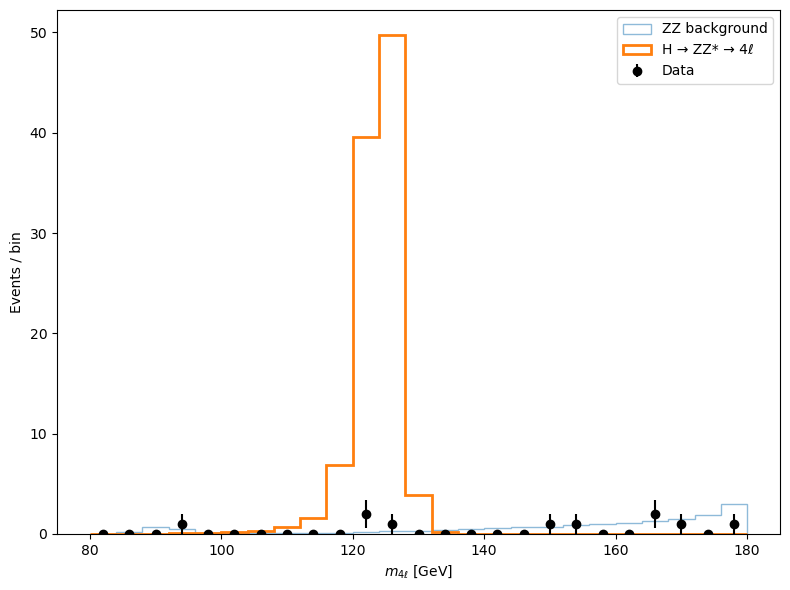

In [ ]:
# Plot: m4l data vs MC
bins = np.linspace(80, 180, 26)

plt.figure(figsize=(8,6))

# Background
plt.hist(
    bkg_sel['m4l'],
    bins=bins,
    weights=bkg_sel['weight'],
    histtype='step',
    alpha=0.5,
    label='ZZ background'
)

# Signal
plt.hist(
    sig_sel['m4l'],
    bins=bins,
    weights=sig_sel['weight'],
    histtype='step',
    linewidth=2,
    label='H → ZZ* → 4ℓ'
)

# Data
plt.errorbar(
    0.5*(bins[1:] + bins[:-1]),
    np.histogram(data_sel['m4l'], bins=bins)[0],
    yerr=np.sqrt(np.histogram(data_sel['m4l'], bins=bins)[0]),
    fmt='o',
    color='black',
    label='Data'
)

plt.xlabel(r'$m_{4\ell}$ [GeV]')
plt.ylabel('Events / bin')
plt.legend()
plt.tight_layout()
plt.show()


### Profile Likelihood

In [82]:
# Asymptotic profile likelihood significance (Cowan et al.)
def profile_likelihood_significance(s, b, k):
    eps = 1e-9
    s = np.array(s) + eps
    b = np.array(b) + eps
    k = np.array(k)

    q0 = 2 * np.sum(k * np.log((s + b) / b) - s)
    return np.sqrt(np.maximum(q0, 0.0))


### Expected Sensitivity

In [83]:
# Expected sensitivity using Asimov dataset
bins = np.linspace(115, 130, 6)  # Higgs window

s_exp, _ = np.histogram(sig_sel['m4l'], bins=bins, weights=sig_sel['weight'])
b_exp, _ = np.histogram(bkg_sel['m4l'], bins=bins, weights=bkg_sel['weight'])

k_asimov = s_exp + b_exp

Z_expected = profile_likelihood_significance(s_exp, b_exp, k_asimov)
print("Expected sensitivity (Asimov):", Z_expected, "σ")


Expected sensitivity (Asimov): 29.444239061518626 σ


### Observed Significance - i think broken?

In [84]:
# Observed significance
k_obs, _ = np.histogram(data_sel['m4l'], bins=bins)

Z_observed = profile_likelihood_significance(s_exp, b_exp, k_obs)
print("Observed significance:", Z_observed, "σ")


Observed significance: 0.0 σ


### Sideband Normalization

In [86]:
# Sideband regions used for background normalization
sb_data = (data_sel['m4l'] > 105) & (data_sel['m4l'] < 160) & ~(
          (data_sel['m4l'] > 115) & (data_sel['m4l'] < 130))

sb_sig = (sig_sel['m4l'] > 105) & (sig_sel['m4l'] < 160) & ~(
         (sig_sel['m4l'] > 115) & (sig_sel['m4l'] < 130))

sb_bkg = (bkg_sel['m4l'] > 105) & (bkg_sel['m4l'] < 160) & ~(
         (bkg_sel['m4l'] > 115) & (bkg_sel['m4l'] < 130))

N_data_sb = sb_data.sum()
N_bkg_sb  = bkg_sel.loc[sb_bkg, 'mcWeight'].sum()

scale = N_data_sb / N_bkg_sb

bkg_sel['w_norm'] = bkg_sel['mcWeight'] * scale
sig_sel['w_norm'] = sig_sel['mcWeight'] * scale


### Higgs Mass Window

In [ ]:
# need to fix

AssertionError: 

In [11]:
#this is as far as i got

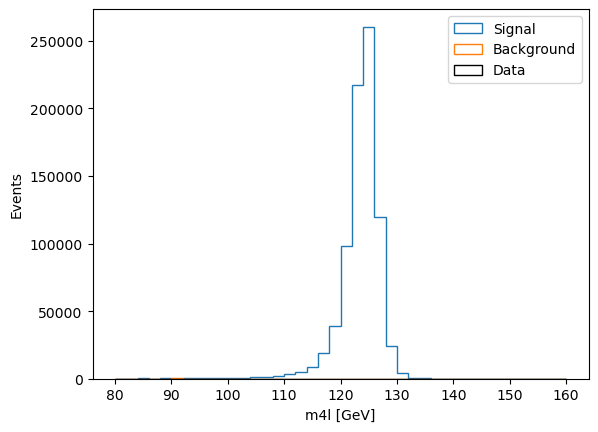

In [12]:
plt.hist(sig3['m4l'], bins=40, range=(80,160),
         weights=sig3['mcWeight'], histtype='step', label='Signal')

plt.hist(bkg3['m4l'], bins=40, range=(80,160),
         weights=bkg3['mcWeight'], histtype='step', label='Background')

plt.hist(data3['m4l'], bins=40, range=(80,160),
         histtype='step', label='Data', color='black')

plt.xlabel('m4l [GeV]')
plt.ylabel('Events')
plt.legend()
plt.show()


In [13]:
# Count events in Higgs window
m_low, m_high = 115, 130
N_data = ((data3['m4l'] > m_low) & (data3['m4l'] < m_high)).sum()
N_sig = sig3.loc[(sig3['m4l'] > 115) & (sig3['m4l'] < 130), 'mcWeight'].sum()
N_bkg = bkg3.loc[(bkg3['m4l'] > 115) & (bkg3['m4l'] < 130), 'mcWeight'].sum()

print(N_data, N_sig, N_bkg)
Z = (N_data - N_bkg)/np.sqrt(N_bkg)
print("Significance ~", Z, "sigma")

3 782013.6316022873 251.20372018008493
Significance ~ -15.660126042754909 sigma


In [14]:
import numpy as np

# Convert each event's pt list to a NumPy array (in GeV), then make a Python list of arrays
list_of_arrays = data1['lep_ptcone30'].apply(lambda x: np.array(x)).tolist()

# Concatenate all arrays into a single 1D array
all_pt = np.concatenate(list_of_arrays)

# Maximum lepton pt
max_pt = all_pt.max()
print(max_pt)

103539.25


In [15]:
# print(df_selected['lep_E'][:10])
plt.hist(df_selected['lep_E'],bins=25)

NameError: name 'df_selected' is not defined

In [14]:
print(np.max(df_selected['lep_eta']))

[2.460472583770752, 2.33640193939209, -0.7088855504989624, -0.1165785863995552]
